### Initializing
$$x = \frac{\phi}{m_p}$$

## Calculating $\phi_{end}/ x_{end}$

In [2]:
import numpy as np
from scipy.optimize import brentq
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [3]:
def derivative_1(V, phi, h=None):
    if h is None:
        h = 1e-6 * max(1.0, abs(phi))
    return (V(phi + h) - V(phi - h)) / (2.0 * h)

def derivative_2(V, phi, h=None):
    if h is None:
        h = 1e-6 * max(1.0, abs(phi))
    return (V(phi + h) - 2.0 * V(phi) + V(phi - h)) / (h * h)

In [4]:
def epsilon_V(V, phi):
    Vval = V(phi)
    if Vval <= 0 or not np.isfinite(Vval):
        return np.nan
    Vp = derivative_1(V, phi)
    return 0.5 * (Vp / Vval)**2

def eta_V(V, phi):
    Vval = V(phi)
    if Vval <= 0 or not np.isfinite(Vval):
        return np.nan
    Vpp = derivative_2(V, phi)
    return Vpp / Vval

In [5]:
def find_phi_end(V, phi_start=30.0, phi_end=0.0, num=5001, refine=True, verbose=True):
    phi_grid = np.linspace(phi_start, phi_end, num)
    eps_arr = np.empty_like(phi_grid)
    eta_arr = np.empty_like(phi_grid)
    for i, phi in enumerate(phi_grid):
        eps_arr[i] = epsilon_V(V, phi)
        eta_arr[i] = eta_V(V, phi)
    mask_break = (eps_arr >= 1.0) | (np.abs(eta_arr) >= 1.0)
    if not np.any(mask_break):
        if verbose:
            print("No slow-roll breaking found in the scanned interval.")
        return {'phi_grid': phi_grid, 'eps': eps_arr, 'eta': eta_arr, 'phi_end': None}
    idx = np.argmax(mask_break)
    phi_cross = phi_grid[idx]
    refined_phi = phi_cross
    if refine and idx > 0:
        a, b = phi_grid[idx-1], phi_grid[idx]
        eps_a, eps_b = eps_arr[idx-1], eps_arr[idx]
        eta_a, eta_b = eta_arr[idx-1], eta_arr[idx]
        if (eps_a - 1.0) * (eps_b - 1.0) <= 0 and np.isfinite(eps_a) and np.isfinite(eps_b):
            def f_eps(phi): return epsilon_V(V, phi) - 1.0
            try:
                refined_phi = brentq(f_eps, a, b, xtol=1e-12, rtol=1e-12, maxiter=200)
            except Exception:
                refined_phi = phi_cross
        else:
            if (eta_a - 1.0) * (eta_b - 1.0) <= 0:
                def f_eta(phi): return eta_V(V, phi) - 1.0
                try:
                    refined_phi = brentq(f_eta, a, b, xtol=1e-12, rtol=1e-12, maxiter=200)
                except Exception:
                    refined_phi = phi_cross
            elif (eta_a + 1.0) * (eta_b + 1.0) <= 0:
                def f_eta_neg(phi): return eta_V(V, phi) + 1.0
                try:
                    refined_phi = brentq(f_eta_neg, a, b, xtol=1e-12, rtol=1e-12, maxiter=200)
                except Exception:
                    refined_phi = phi_cross
            else:
                refined_phi = phi_cross
    return {'phi_grid': phi_grid, 'eps': eps_arr, 'eta': eta_arr, 'phi_end': refined_phi, 'index': idx}

### Quadratic Potential

In [59]:
def f_quad(x):
    return x**2

In [74]:
res = find_phi_end(f_quad)
print("Refined phi_end for quadratic:", res['phi_end'], " expected value =", np.sqrt(2.0))

Refined phi_end for quadratic: 1.4142135624187149  expected value = 1.4142135623730951


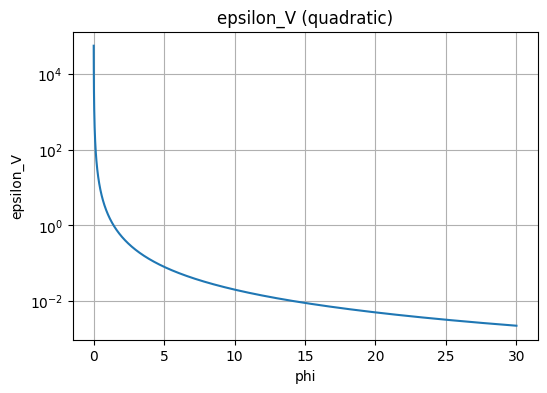

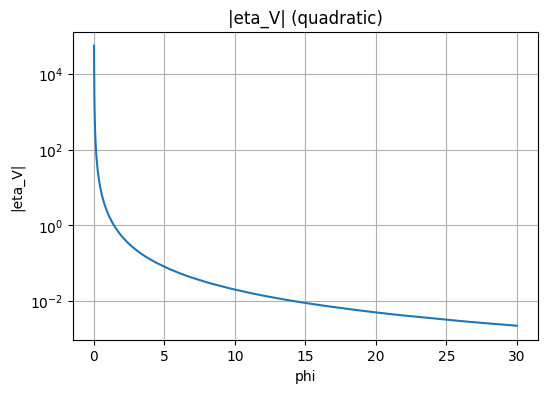

In [8]:
# Plot epsilon and |eta| vs phi (separate plots)
plt.figure(figsize=(6,4))
plt.plot(res['phi_grid'], res['eps'])
plt.yscale('log')
plt.xlabel('phi')
plt.ylabel('epsilon_V')
plt.title('epsilon_V (quadratic)')
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(res['phi_grid'], np.abs(res['eta']))
plt.yscale('log')
plt.xlabel('phi')
plt.ylabel('|eta_V|')
plt.title('|eta_V| (quadratic)')
plt.grid(True)
plt.show()

### Starobinsky Potential

In [61]:
def f_staro(x):
    return (1 - np.exp(-np.sqrt(2.0/3) * x))**2

In [75]:
res = find_phi_end(f_staro, phi_start=30.0, phi_end=0.0, num=5001, refine=True, verbose=True)
print("Refined phi_end for starobinsky:", res['phi_end'], " expected value =", np.sqrt(3.0/2)*np.log(1+2/np.sqrt(3)))

Refined phi_end for starobinsky: 0.9401775470482965  expected value = 0.9401775470003004


## Calculating $\phi_i/ x_i$

In [124]:
# --- E-folds N(phi) ---
def N_of_phi(V, phi, phi_end):
    """Compute number of e-folds from phi down to phi_end."""
    def integrand(phi_val):
        Vval = V(phi_val)
        Vp = derivative_1(V, phi_val)
        if Vval <= 0 or not np.isfinite(Vval) or Vp == 0:
            return 0.0
        return Vval / Vp
    N, _ = quad(integrand, phi_end, phi, limit = 1000)
    return N

In [99]:
# --- Find phi for given Ne ---
def find_phi(V, phi_end, Ne, range_end = 30.0):
    def f(phi):
        return N_of_phi(V, phi, phi_end) - Ne
    bracket=(phi_end+1e-3, range_end)
    phi = brentq(f, bracket[0], bracket[1], xtol=1e-12, rtol=1e-12, maxiter=200)
    return phi

### Quadratic Potential

In [122]:
info = find_phi_end(f_quad)
phi_end = info['phi_end']
print("phi_end =", phi_end)

Nt = 77.5
phi_i = find_phi(f_quad, phi_end, Nt)
print("phi_i =", phi_i)

print("Check: N(phi_i) =", N_of_phi(f_quad, phi_i, phi_end))

phi_end = 1.4142135624187149
phi_i = 17.663521732636003
Check: N(phi_i) = 77.49999999970923


### Starobinsky Potential

In [125]:
info = find_phi_end(f_staro)
phi_end = info['phi_end']
print("phi_end =", phi_end)

Nt = 77.5
phi_i = find_phi(f_staro, phi_end, Nt)
print("phi_i =", phi_i)

print("Check: N(phi_i) =", N_of_phi(f_staro, phi_i, phi_end))

phi_end = 0.9401775470482965
phi_i = 5.750364412236544
Check: N(phi_i) = 77.4999999983001


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19720\3477671310.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  N, _ = quad(integrand, phi_end, phi, limit = 1000)


## Calculating $V_0$ of Voltage (From Scalar Power Spectra at CMB scale)

### Quadratic Potential

In [126]:
info = find_phi_end(f_quad)
phi_end = info['phi_end']

N_star = 60   # Ne at CMB PIvot Scale
Ps = 2.1e-9

phi_star = find_phi(f_quad, phi_end, N_star)
print("phi_star =", phi_star)

print("Check: N(phi_i) =", N_of_phi(f_quad, phi_star, phi_end))

phi_star = 15.55634918613191
Check: N(phi_i) = 59.99999999978591


In [127]:
epsilon_star = epsilon_V(f_quad, phi_star)

print("epsilon_star =", epsilon_star)

epsilon_star = 0.008264462810319


In [128]:
def Vo(Ps, phi, V):
    return 24 *np.pi**2 *Ps *epsilon_V(V,phi) / V(phi)

In [129]:
Vo_quad = Vo(Ps, phi_star, f_quad)

print("Coefficient of Voltage, Vo =", Vo_quad)

Coefficient of Voltage, Vo = 1.698750296555208e-11


### Starobinsky Potential

In [130]:
info = find_phi_end(f_staro)
phi_end = info['phi_end']

N_star = 60   # Ne at CMB PIvot Scale
Ps = 2.1e-9

phi_star = find_phi(f_staro, phi_end, N_star)
print("phi_star =", phi_star)

print("Check: N(phi_i) =", N_of_phi(f_staro, phi_star, phi_end))

phi_star = 5.453151560376917
Check: N(phi_i) = 59.99999999965871


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19720\3477671310.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  N, _ = quad(integrand, phi_end, phi, limit = 1000)


In [131]:
epsilon_star = epsilon_V(f_quad, phi_star)

print("epsilon_star =", epsilon_star)

epsilon_star = 0.06725659230827075


In [132]:
Vo_staro = Vo(Ps, phi_star, f_staro)

print("Coefficient of Voltage, Vo =", Vo_staro)

Coefficient of Voltage, Vo = 9.433018406153045e-11
